In [1]:
import random
import keras
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional, GRU
from keras.layers import TimeDistributed, Conv2D, Reshape, Masking
from keras.optimizers import Adam
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from IPython.display import clear_output
from sklearn.metrics import precision_recall_fscore_support

import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from tabulate import tabulate

I:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class DataSet(object):
    """class for out datasets"""

    def __init__(self,
                 x_train: np.ndarray,
                 y_train: np.ndarray,
                 x_val: np.ndarray,
                 y_val: np.ndarray,
                 x_test: np.ndarray,
                 y_test: np.ndarray,
                 class_names: [str] = None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        self.class_names = class_names

    @staticmethod
    def from_np_array(x: np.ndarray, y: np.ndarray, class_names: [str] = None, p_train=0.6, p_val=0.2, shuffle=False):

        if shuffle:
            np.random.seed(43)
            idx = np.arange(x.shape[0])
            np.random.shuffle(idx)
            x = x[idx]
            y = y[idx]

        n = x.shape[0]
        n_train = int(n * p_train)
        n_val = int(n * p_val)

        x_train = x[:n_train]
        y_train = y[:n_train]
        x_val = x[n_train:n_train + n_val]
        y_val = y[n_train:n_train + n_val]
        x_test = x[n_train + n_val:]
        y_test = y[n_train + n_val:]

        return DataSet(x_train, y_train, x_val, y_val, x_test, y_test, class_names)

    def plot_distribution(self, set: str):
        """
            set: 'train', 'val', 'test' or 'all'
        """
        classes = self.class_names
        labels = None
        if set == 'train':
            labels = self.y_train
        elif set == 'val':
            labels = self.y_val
        elif set == 'test':
            labels = self.y_test
        elif set == 'all':
            labels = np.concatenate((self.y_train, self.y_val, self.y_test))
        else:
            raise AttributeError("set must be train, val, test or all")

        class_counts = []
        class_tuples = []

        for i, c in enumerate(classes):
            lsum = np.sum(labels == i)
            class_counts.append(lsum)
            class_tuples.append((classes[i], lsum))

        print(tabulate(class_tuples, headers=('name', 'count')))

        plt.figure()
        plt.title(set + " class distribution")
        plt.bar(np.arange(len(class_counts)), class_counts)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.show()

    def save(self, path: str):
        if not os.path.exists(path):
            os.makedirs(path)

        np.save(path + "x_test.npy", self.x_test)
        np.save(path + "y_test.npy", self.y_test)
        np.save(path + "x_val.npy", self.x_val)
        np.save(path + "y_val.npy", self.y_val)
        np.save(path + "x_train.npy", self.x_train)
        np.save(path + "y_train.npy", self.y_train)

    @staticmethod
    def load(path:str, class_names:str = None):
        x_test = np.load(path + "x_test.npy")
        y_test = np.load(path + "y_test.npy")
        x_val = np.load(path + "x_val.npy")
        y_val = np.load(path + "y_val.npy")
        x_train = np.load(path + "x_train.npy")
        y_train = np.load(path + "y_train.npy")
        return DataSet(x_train, y_train, x_val, y_val, x_test, y_test, class_names)

    def __str__(self):
        return f"Train set: {self.x_train.shape[0]} samples \nValidation set: {self.x_val.shape[0]} samples \nTest set: {self.x_test.shape[0]} samples"


In [3]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1

    def plot(self):
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.plt()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-7)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def create_and_plot_confusion_matrix(y_true:np.ndarray, y_pred:np.ndarray, class_names:[str]):
    # Compute confusion matrix
    if y_true.ndim == 2:
        cnf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    else:
        cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    plt.subplot(1, 2, 2)
    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

In [5]:
class SentimentAnalyser():
    """description of class"""

    def __init__(self, dataset: "DataSet", n_neurons=16, verbose=1, learning_rate=0.001, max_lenght=300, model: Sequential = None): 
        self.history = {}
        self.verbose = verbose

        print("Loading spaCy")
        nlp = spacy.load('en_vectors_web_lg')
        nlp.add_pipe(nlp.create_pipe('sentencizer'))
        embeddings = nlp.vocab.vectors.data # get embbedings

        if(os.path.isfile("data/data_set32/x_train.npy")):
            dataset = DataSet.load("data/data_set32/", dataset.class_names)
        else:
            self.preprocess(nlp, dataset, max_lenght)
            dataset.save("data_set32/data_set/")

        dataset.y_train = keras.utils.to_categorical(dataset.y_train)
        dataset.y_val = keras.utils.to_categorical(dataset.y_val)
        dataset.y_test = keras.utils.to_categorical(dataset.y_test)

        rnn_shape = {'nr_hidden': n_neurons, 'max_length': max_lenght, 'nr_class': len(dataset.class_names)}
        rnn_settings = {'dropout': 0.5, 'lr': 0.001}

        if model is None:
            self.model = self.compile_rnn(embeddings, rnn_shape, rnn_settings)
        else:
            self.model = model

        self.ds = dataset
        print(self.model.summary())

    def preprocess(self, nlp, ds: "DataSet", max_length):
        print("Parsing texts...")
        train_docs = list(nlp.pipe(ds.x_train))
        val_docs = list(nlp.pipe(ds.x_val))
        test_docs = list(nlp.pipe(ds.x_test))

        train_X = self.get_features(train_docs, max_length)
        val_X = self.get_features(val_docs, max_length)
        test_X = self.get_features(test_docs, max_length)

        ds.x_train = train_X
        ds.x_val = val_X
        ds.x_test = test_X

    def get_features(self, docs, max_length):
        docs = list(docs)
        Xs = np.zeros((len(docs), max_length), dtype='int32')
        for i, doc in enumerate(docs):
            j = 0
            for token in doc:
                vector_id = token.vocab.vectors.find(key=token.orth)
                if vector_id >= 0:
                    Xs[i, j] = vector_id
                else:
                    Xs[i, j] = 0
                j += 1
                if j >= max_length:
                    break
        return Xs

    def compile_rnn(self, embeddings, shape, settings):
        model = Sequential()

        model.add(
            Embedding(
                embeddings.shape[0],
                embeddings.shape[1],
                input_length=shape['max_length'],
                trainable=False,
                weights=[embeddings],
                mask_zero=True
            )
        )

        model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
        model.add(Bidirectional(GRU(shape['nr_hidden'],
                                     recurrent_dropout=settings['dropout'],
                                     dropout=settings['dropout'])))
        model.add(Dense(shape['nr_class'], activation='sigmoid'))
        model.compile(optimizer=Adam(lr=settings['lr']), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, chekpoint_path, epochs=100):
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(chekpoint_path + "epoch_{epoch:02d}-val_los_{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=4)

        plot = PlotLearning()

        self.model.fit(self.ds.x_train, self.ds.y_train, validation_data=(self.ds.x_val, self.ds.y_val),
                          epochs=epochs, batch_size=500, callbacks=[model_checkpoint_callback, plot], verbose=self.verbose)

        plot.plot()

    def validate(self):
        loss, accuracy = self.model.evaluate(self.ds.x_test, self.ds.y_test, batch_size=128)
        
        
        print(f"loss: \t {loss:04.2f}")
        print(f"accuracy: \t {accuracy:04.2f}")

        return accuracy

    def predict(self, x: any) -> [any]:
        p = self.model.predict(x)
        z = np.zeros_like(p)
        z[np.arange(len(p)), p.argmax(1)] = 1
        return z

    def predict_proba(self, x):
        return self.model.predict_proba(x)

    def save(self, path: str):
        self.model.save(path)

    def metrics_task1(self):
        y_true = self.ds.y_test
        y_pred = self.predict(self.ds.x_test)

        (precision, recall, fscore, _) = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        print(f"precision: \t {precision:04.2f}")
        print(f"recall: \t {recall:04.2f}")
        print(f"fscore: \t {fscore:04.2f}")

    def metrics_task2(self):
        y_true = self.ds.y_test
        y_pred = self.predict(self.ds.x_test)

        y_true = [one_hot[3] + one_hot[4] for one_hot in y_true]
        y_pred = [one_hot[3] + one_hot[4] for one_hot in y_pred]
        
        (precision, recall, fscore, _) = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        print(f"precision: \t {precision:04.2f}")
        print(f"recall: \t {recall:04.2f}")
        print(f"fscore: \t {fscore:04.2f}")

    def metrics_task3(self):
        y_true = self.ds.y_test
        y_pred = self.predict(self.ds.x_test)

        y_true = [one_hot[1] + one_hot[2] + one_hot[3] + one_hot[4] for one_hot in y_true]
        y_pred = [one_hot[1] + one_hot[2] + one_hot[3] + one_hot[4] for one_hot in y_pred]
        
        #(precision, recall, fscore, _) = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        (precision, recall, fscore, _) = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        print(f"precision: \t {precision:04.2f}")
        print(f"recall: \t {recall:04.2f}")
        print(f"fscore: \t {fscore:04.2f}")

    def plot_confusion_matrix(self):
        y_true = self.ds.y_test
        y_pred = self.predict(self.ds.x_test)

        class_names = []
        if self.ds.class_names == None:
            le = LabelEncoder()
            le.fit(y_true)
            class_names = le.classes_
        else:
            class_names = self.ds.class_names


        create_and_plot_confusion_matrix(y_true, y_pred, class_names)
    
    @staticmethod
    def load(path: str, dataset: "DataSet") -> "RandomForest":
        model = keras.models.load_model(path)
        return SentimentAnalyser(dataset, model=model)

In [6]:
nlp = spacy.load("en_core_web_sm")

emotional_words = "anger sad happy joy"
emotional_tokens = list(nlp.pipe(emotional_words))

def emotionality_component(doc):
    score = 0.
    count = 0
    for token in doc:
        max = 0
        if(token.is_stop): continue
        count += 1
        for emotional_token in emotional_tokens:
            sim = token.similarity(emotional_token)
            if(sim > max): max = sim
        score += max
    doc.user_data['emotionality'] = score/count
    return doc

nlp.add_pipe(emotionality_component, last=True)

def findBestEmotional(texts: [str]):
    scores = []

    docs = nlp.pipe(texts, batch_size=100, n_threads=8)
    docs = list(sorted(docs, key=lambda d: d.user_data['emotionality'], reverse=True))

    return docs

In [7]:
def load_document():
    """ returns a dataframe with the collums 'sentimens', 'product', 'review'"""
    df = pd.read_csv("Amazon_Baby_train.txt", sep=';', header=None)
    df.columns = ['sentimens', 'product', 'review']
    df.sentimens = df.sentimens - 1
    return df

In [8]:
def load_doc_vec(df: pd.DataFrame):
    """ returns tuple with
            document vectors with the shape (n_samples, doc_vec_dimention)
            labels with the shape (n_samples)
    """

    if(os.path.isfile("data/x_document.npy") and os.path.isfile("data/y_document.npy")):
        x = np.load("data/x_document.npy")
        y = np.load("data/y_document.npy")
    else:
        nlp = sp.load("en_core_web_sm")

        docs = list(nlp.pipe(df['review']))
        x = np.zeros((df.shape[0], docs[0].vector.shape[0]))
        y = np.array(df['sentimens'], dtype=np.int32)

        for i, doc in enumerate(docs):
            x[i,:] = doc.vector

        np.save("data/x_document.npy", x)
        np.save("data/y_document.npy", y)
    return x, y

### Create Data Set

  name    count
------  -------
     1    11084
     2     8094
     3    11982
     4    23925
     5    77089


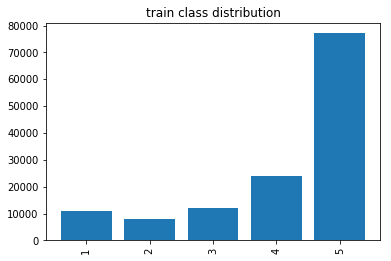

  name    count
------  -------
     1      602
     2      457
     3      652
     4     1294
     5     4338


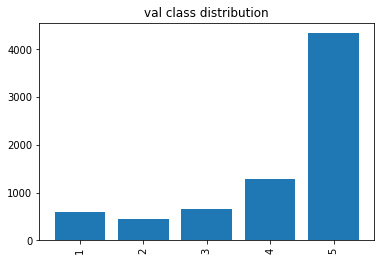

  name    count
------  -------
     1      569
     2      485
     3      682
     4     1270
     5     4338


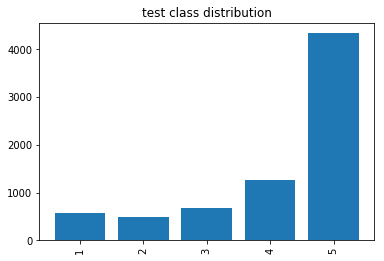

  name    count
------  -------
     1    12255
     2     9036
     3    13316
     4    26489
     5    85765


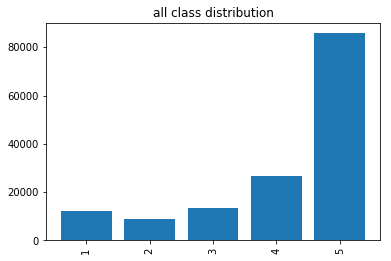

In [9]:
df = load_document()
ds = DataSet.from_np_array(df['review'], np.asarray(df['sentimens'], dtype='int32'), class_names=[1,2,3,4,5], shuffle=True, p_train=0.9, p_val=0.05)
ds.plot_distribution('train')
ds.plot_distribution('val')
ds.plot_distribution('test')
ds.plot_distribution('all')

### Sentimets analizer

Loading spaCy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 300)          321291300 
_________________________________________________________________
time_distributed_1 (TimeDist (None, 400, 32)           9600      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12480     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 321,313,705
Trainable params: 22,405
Non-trainable params: 321,291,300
_________________________________________________________________
None

 All classes
precision: 	 0.69
recall: 	 0.72
fscore: 	 0.70


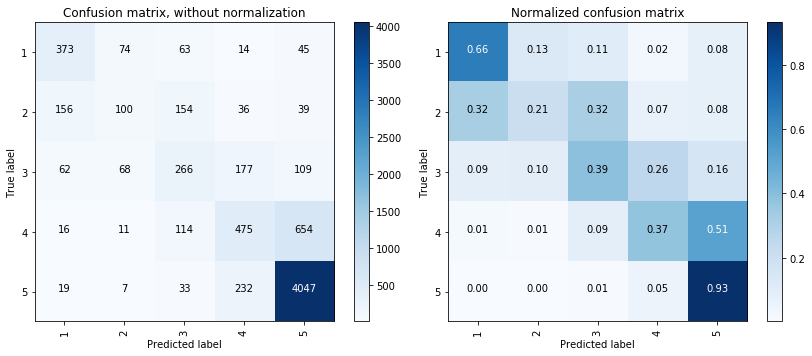


 class 1:(1,2,3) class 2: (4, 5)
precision: 	 0.91
recall: 	 0.92
fscore: 	 0.91

 class1 :(1) class 2:(2,3,4,5)
precision: 	 0.94
recall: 	 0.94
fscore: 	 0.94


In [ ]:
path = "checkpoints/gru32/epoch_76-val_los_0.68.hdf5"

if os.path.isfile(path):
    classifier = SentimentAnalyser.load(path, ds)
else:
    classifier = SentimentAnalyser(ds, n_neurons = 32, max_lenght=400)

#classifier.fit("checkpoints/gru32/", 80)
print("\nAll classes")
#classifier.validate()
classifier.metrics_task1()
classifier.plot_confusion_matrix()

print("\nclass 1:(1,2,3) class 2: (4, 5)")
classifier.metrics_task2()
print("\nclass 1:(1) class 2:(2,3,4,5)")
classifier.metrics_task3()

### Emotionality

In [ ]:
texts = list(df['review'])
texts = [text for text in texts if text.strip() != '']
best = findBestEmotional(texts)
print([(doc.user_data['emotionality'], doc.text) for doc in best[:5]])